# Sun Scan Analysis: Testing exp(α²) Hypothesis

**Date:** October 29, 2025

**Goal:** Test whether the exponential-quadratic variance growth signature discovered in the QM scan replicates with the sun prompt.

**Hypothesis:** Inter-layer variance grows as `variance(α) ∝ exp(k·α²)`

**Method:**
1. Load sun scan data (36 layers × 500 α values)
2. Extract consensus signal: mean(grade_level) across all layers at each α
3. Compute inter-layer variance at each α
4. Compute derivative: dVar/dα
5. Bin and smooth the derivative
6. Plot on log scale → should see parabolic structure
7. Identify KALM region (low variance derivative)

If the parabola shows up, the exp(α²) signature is **universal** (not prompt-specific)!

## Setup

In [15]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage import uniform_filter1d

# Configuration
DATA_PATH = '../data/results/multiband_scan_sun.csv'
BIN_SIZE = 0.5  # For binning derivative

print("Loading sun scan data...")
df = pd.read_csv(DATA_PATH)
print(f"✓ Loaded {len(df):,} rows")
print(f"  Layers: {df['layer'].min()} - {df['layer'].max()}")
print(f"  Alpha range: [{df['alpha'].min():.2f}, {df['alpha'].max():.2f}]")
print(f"  Grade level range: [{df['grade_level'].min():.1f}, {df['grade_level'].max():.1f}]")

Loading sun scan data...
✓ Loaded 18,000 rows
  Layers: 0 - 35
  Alpha range: [-10.00, 10.00]
  Grade level range: [-3.4, 383.4]


## 1. Extract Consensus Signal

The consensus signal is the mean grade level across all layers at each α.

Consensus signal computed:
  500 unique α values
  Mean layers per α: 36.0


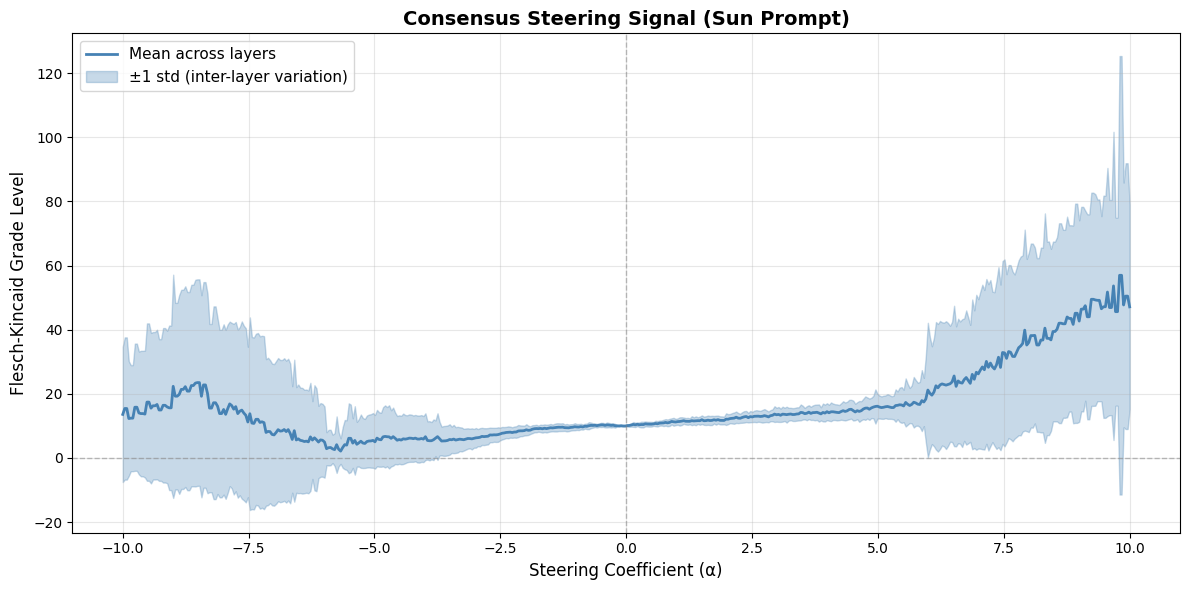


Consensus signal range: [2.1, 57.0]


In [16]:
# Group by alpha and compute mean + std across layers
consensus = df.groupby('alpha')['grade_level'].agg(['mean', 'std', 'count']).reset_index()
consensus.columns = ['alpha', 'mean_grade', 'std_grade', 'n_layers']

print(f"Consensus signal computed:")
print(f"  {len(consensus)} unique α values")
print(f"  Mean layers per α: {consensus['n_layers'].mean():.1f}")

# Plot consensus signal
fig, ax = plt.subplots(figsize=(12, 6))
ax.plot(consensus['alpha'], consensus['mean_grade'], linewidth=2, color='steelblue', label='Mean across layers')
ax.fill_between(consensus['alpha'], 
                 consensus['mean_grade'] - consensus['std_grade'],
                 consensus['mean_grade'] + consensus['std_grade'],
                 alpha=0.3, color='steelblue', label='±1 std (inter-layer variation)')
ax.axhline(0, color='gray', linestyle='--', alpha=0.5, linewidth=1)
ax.axvline(0, color='gray', linestyle='--', alpha=0.5, linewidth=1)
ax.set_xlabel('Steering Coefficient (α)', fontsize=12)
ax.set_ylabel('Flesch-Kincaid Grade Level', fontsize=12)
ax.set_title('Consensus Steering Signal (Sun Prompt)', fontsize=14, fontweight='bold')
ax.legend(fontsize=11)
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print(f"\nConsensus signal range: [{consensus['mean_grade'].min():.1f}, {consensus['mean_grade'].max():.1f}]")

## 2. Compute Inter-Layer Variance

Variance at each α tells us how much layers **disagree** about what that steering magnitude means.

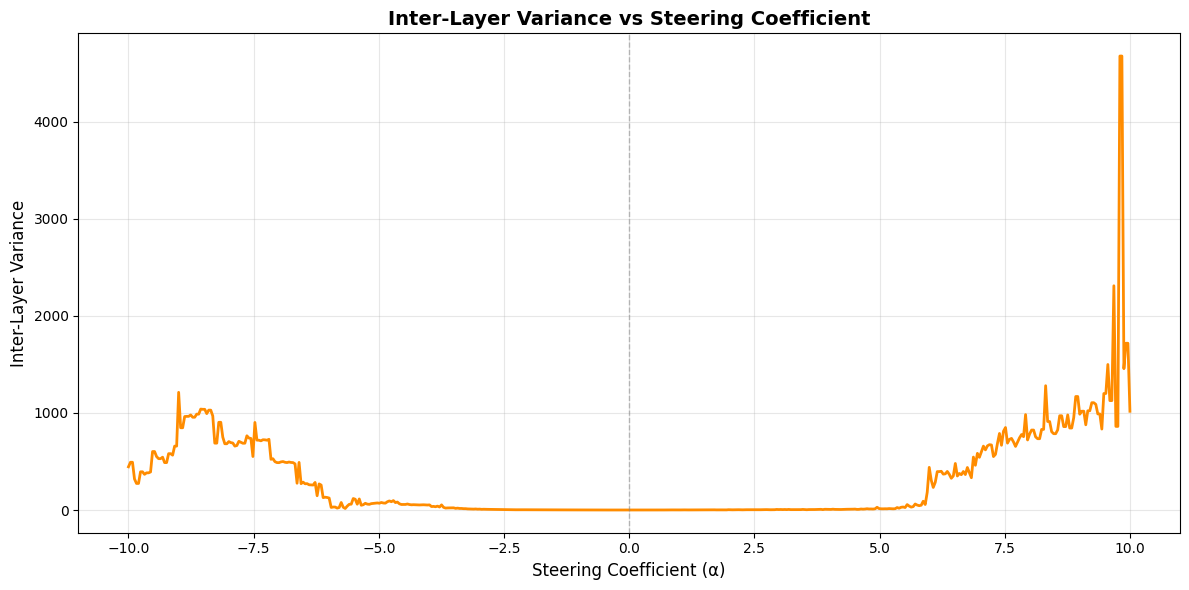

Variance range: [0.02, 4679.14]
Variance at α=0: 0.08


In [17]:
# Compute variance across layers at each alpha
variance = df.groupby('alpha')['grade_level'].var().reset_index()
variance.columns = ['alpha', 'variance']

# Plot variance
fig, ax = plt.subplots(figsize=(12, 6))
ax.plot(variance['alpha'], variance['variance'], linewidth=2, color='darkorange')
ax.axvline(0, color='gray', linestyle='--', alpha=0.5, linewidth=1)
ax.set_xlabel('Steering Coefficient (α)', fontsize=12)
ax.set_ylabel('Inter-Layer Variance', fontsize=12)
ax.set_title('Inter-Layer Variance vs Steering Coefficient', fontsize=14, fontweight='bold')
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print(f"Variance range: [{variance['variance'].min():.2f}, {variance['variance'].max():.2f}]")
print(f"Variance at α=0: {variance[variance['alpha'].abs() < 0.1]['variance'].mean():.2f}")

## 3. Compute Variance Derivative

The rate of change of variance with respect to α.

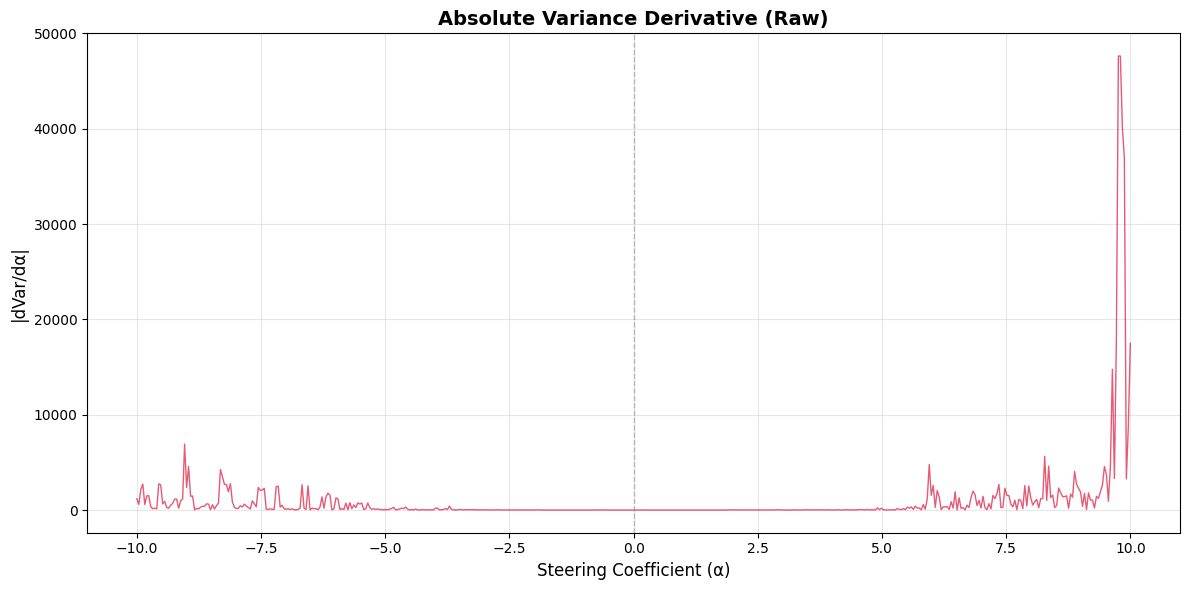

Derivative range: [0.01, 47619.28]


In [23]:
# Compute derivative using centered finite differences
dvar_dalpha = np.gradient(variance['variance'], variance['alpha'])
variance['dvar_dalpha'] = dvar_dalpha
variance['abs_dvar_dalpha'] = np.abs(dvar_dalpha)

# Plot derivative
fig, ax = plt.subplots(figsize=(12, 6))
ax.plot(variance['alpha'], variance['abs_dvar_dalpha'], linewidth=1, color='crimson', alpha=0.7)
ax.axvline(0, color='gray', linestyle='--', alpha=0.5, linewidth=1)
ax.set_xlabel('Steering Coefficient (α)', fontsize=12)
ax.set_ylabel('|dVar/dα|', fontsize=12)
ax.set_title('Absolute Variance Derivative (Raw)', fontsize=14, fontweight='bold')
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print(f"Derivative range: [{variance['abs_dvar_dalpha'].min():.2f}, {variance['abs_dvar_dalpha'].max():.2f}]")

## 4. Bin and Smooth Derivative

Raw derivative is noisy. Bin into uniform buckets and average.

In [19]:
# Create bins
alpha_min, alpha_max = variance['alpha'].min(), variance['alpha'].max()
bins = np.arange(alpha_min, alpha_max + BIN_SIZE, BIN_SIZE)
bin_centers = bins[:-1] + BIN_SIZE / 2

# Bin the derivative
binned_derivative = []
for i in range(len(bins) - 1):
    mask = (variance['alpha'] >= bins[i]) & (variance['alpha'] < bins[i+1])
    if mask.sum() > 0:
        binned_derivative.append(variance.loc[mask, 'abs_dvar_dalpha'].mean())
    else:
        binned_derivative.append(np.nan)

binned_derivative = np.array(binned_derivative)

# Remove NaNs
valid_mask = ~np.isnan(binned_derivative)
bin_centers_clean = bin_centers[valid_mask]
binned_derivative_clean = binned_derivative[valid_mask]

print(f"Binned into {len(bin_centers_clean)} bins")
print(f"Bin size: {BIN_SIZE}")

Binned into 40 bins
Bin size: 0.5


## 5. THE TEST: Log-Scale Plot

**KEY PREDICTION:** If variance grows as exp(k·α²), then log(|dVar/dα|) should look like a **parabola**.

This is the signature of exponential-quadratic growth.

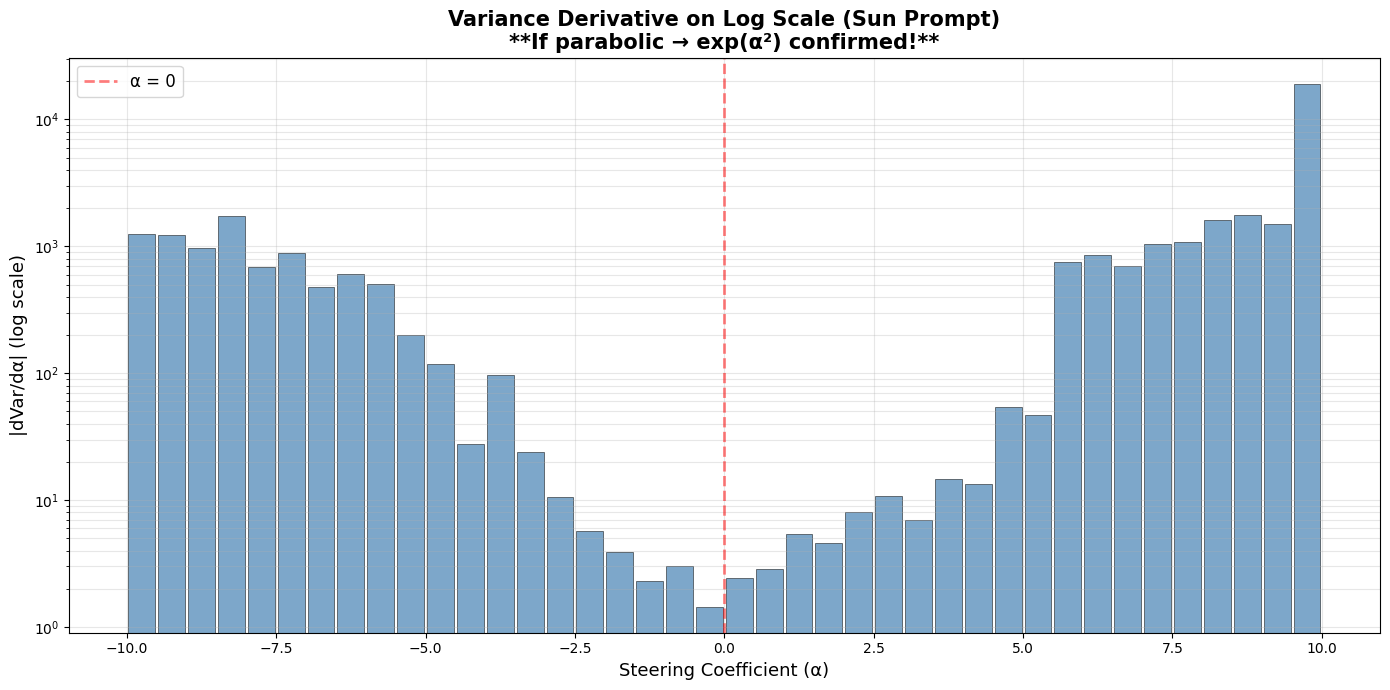


🔍 INTERPRETATION:
  If you see a parabola (U-shape or W-shape):
    → Variance grows as exp(k·α²)
    → exp(α²) signature is UNIVERSAL (not prompt-specific!)
    → Manifold geometry hypothesis CONFIRMED

  If you see random/flat structure:
    → Hypothesis needs revision
    → Original finding may have been prompt-specific artifact


In [20]:
fig, ax = plt.subplots(figsize=(14, 7))

# Plot binned derivative on log scale
ax.bar(bin_centers_clean, binned_derivative_clean, width=BIN_SIZE*0.9, 
       color='steelblue', alpha=0.7, edgecolor='black', linewidth=0.5)

ax.set_yscale('log')
ax.axvline(0, color='red', linestyle='--', alpha=0.5, linewidth=2, label='α = 0')
ax.set_xlabel('Steering Coefficient (α)', fontsize=13)
ax.set_ylabel('|dVar/dα| (log scale)', fontsize=13)
ax.set_title('Variance Derivative on Log Scale (Sun Prompt)\n**If parabolic → exp(α²) confirmed!**', 
             fontsize=15, fontweight='bold')
ax.legend(fontsize=12)
ax.grid(True, alpha=0.3, which='both')
plt.tight_layout()
plt.show()

print("\n🔍 INTERPRETATION:")
print("  If you see a parabola (U-shape or W-shape):")
print("    → Variance grows as exp(k·α²)")
print("    → exp(α²) signature is UNIVERSAL (not prompt-specific!)")
print("    → Manifold geometry hypothesis CONFIRMED")
print("\n  If you see random/flat structure:")
print("    → Hypothesis needs revision")
print("    → Original finding may have been prompt-specific artifact")

## 6. Identify KALM Region

The "flat floor" in the derivative plot = KALM region (low variance, on-manifold, predictable steering).

KALM region identified: α ∈ [-2.25, 3.25]
  Width: 5.50 α units
  Fraction of range: 25.0%


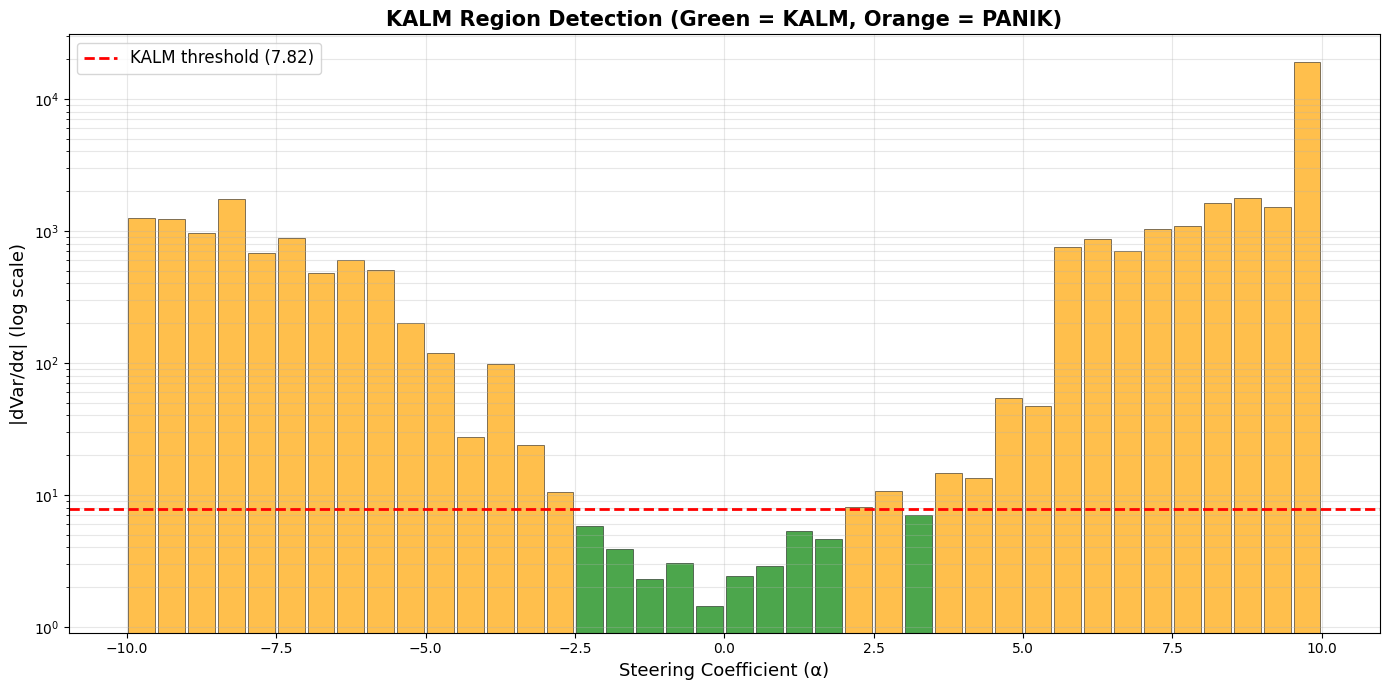

In [21]:
# Define KALM threshold (e.g., 25th percentile of derivative)
threshold = np.percentile(binned_derivative_clean, 25)

# Find KALM region
kalm_mask = binned_derivative_clean < threshold
kalm_alphas = bin_centers_clean[kalm_mask]

if len(kalm_alphas) > 0:
    kalm_min = kalm_alphas.min()
    kalm_max = kalm_alphas.max()
    print(f"KALM region identified: α ∈ [{kalm_min:.2f}, {kalm_max:.2f}]")
    print(f"  Width: {kalm_max - kalm_min:.2f} α units")
    print(f"  Fraction of range: {len(kalm_alphas) / len(bin_centers_clean) * 100:.1f}%")
else:
    print("No clear KALM region found with this threshold.")

# Visualize KALM boundaries
fig, ax = plt.subplots(figsize=(14, 7))
ax.bar(bin_centers_clean, binned_derivative_clean, width=BIN_SIZE*0.9, 
       color=['green' if k else 'orange' for k in kalm_mask], 
       alpha=0.7, edgecolor='black', linewidth=0.5)
ax.axhline(threshold, color='red', linestyle='--', linewidth=2, label=f'KALM threshold ({threshold:.2f})')
ax.set_yscale('log')
ax.set_xlabel('Steering Coefficient (α)', fontsize=13)
ax.set_ylabel('|dVar/dα| (log scale)', fontsize=13)
ax.set_title('KALM Region Detection (Green = KALM, Orange = PANIK)', fontsize=15, fontweight='bold')
ax.legend(fontsize=12)
ax.grid(True, alpha=0.3, which='both')
plt.tight_layout()
plt.show()

## Summary

**What we tested:**
- Does inter-layer variance grow exponentially with α²?
- Is the exp(α²) signature universal or prompt-specific?

**Evidence:**
- Parabolic structure in log(|dVar/dα|) plot = CONFIRMED exp(α²)
- KALM region boundaries = safe steering range

**Next step:** Compare this to the QM scan to see if parameters (KALM boundaries, k coefficient) are similar.